# Snaps correction (1st step)

## - Requirements:

### * Segmentation channel images within a folder called 'tifrfip'
### * If there's a second channel images must be within a folder called 'tifgfp'

## - Output:

### * Shading-Corrected .tif images for both channels
### * .jpeg masks for segmentation

In [1]:
# If you need more information on any of the libraries used, please consult their respective documentation33
%matplotlib inline
import cv2
from matplotlib import pyplot as plt
import os 
from glob import glob 
import numpy as np 

In [2]:
#Parameters#
s = 1 # Scaling factor tif
jpegmax = 255 # max value for jpeg masks

### The adquisition pictures must be stored in separate folders discriminated by fluorescent channel, below are listed the folder names:

#### Segmentation channel = "tifrfp" 

#### Signal channel = "tifgfp"

### Aditionally please store the camera dark image and shading correction for both channels in a folder named:

#### corrections folder = "corrections".

In [3]:
files_tifrfp = []
files_tifgfp = []


tif_dirrfp = './tifrfp' 
tif_dirgfp = './tifgfp' 
pattern_tif = "*.tif" 
correction_dir = './corrections'

for dir,_,_ in os.walk(tif_dirrfp):
    files_tifrfp.extend(glob(os.path.join(dir,pattern_tif)))

for dir,_,_ in os.walk(tif_dirgfp):
    files_tifgfp.extend(glob(os.path.join(dir,pattern_tif)))

position_names =  [x[1] for x in os.walk(tif_dirrfp)][0]

files_tifrfp.sort()
files_tifrfp = np.array(files_tifrfp).reshape(len(position_names),\
                (int(len(files_tifrfp)/len(position_names)))).tolist()

files_tifgfp.sort()
files_tifgfp = np.array(files_tifgfp).reshape(len(position_names),\
                (int(len(files_tifgfp)/len(position_names)))).tolist()



if len(files_tifgfp[0]) == 0:
    GFPimages = False
else: 
    GFPimages = True
    

print (str(len(position_names)) + ' positions were found')
print(str(len(files_tifrfp[0])) + ' RFP images found per position')
print(str(len(files_tifgfp[0])) + ' GFP images found per position')

3 positions were found
4 RFP images found per position
0 GFP images found per position


### Here the images will be corrected using a flat field correction, further information on this protocol can be found [here](http://nic.ucsf.edu/blog/2014/01/shading-correction-of-fluorescence-images/).

### Also the corrected images will be saved in a different folder, a lower quality copy of the images saved to a different folder as well, is going to be used for segmentation purposes.

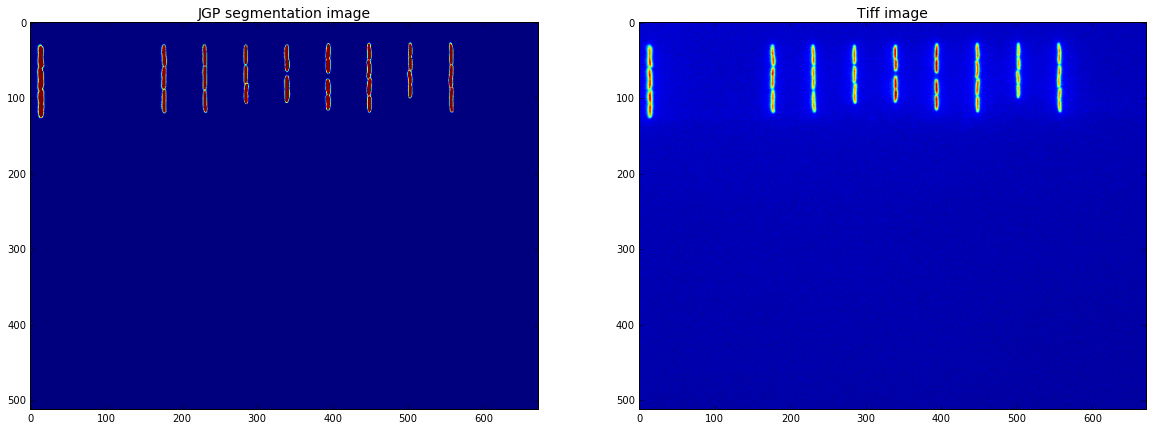

In [4]:
AVG_Dark   = cv2.imread('./corrections/AVG_Dark.tif', 2 | 4)
AVG_TotalGREEN = cv2.imread('./corrections/AVG_TotalGreen.tif', 2 | 4)
AVG_TotalRED = cv2.imread('./corrections/AVG_TotalRED.tif', 2 | 4)


file = files_tifrfp[0][np.random.randint(0, len(files_tifrfp[0]))]
img = cv2.imread(file, 2 | 4)
correctedimg = np.zeros_like(img)
correctedimgjpg = np.zeros_like(img)
maxi = np.mean(AVG_TotalRED)

for l in range (len(img)):
    for m in range (len(img[0])):
        if (img[l][m] > AVG_Dark[l][m]):
            tmp = maxi * (img[l][m] - AVG_Dark[l][m]) / (AVG_TotalRED[l][m])
            correctedimg[l][m] = s * tmp 
c = np.max(correctedimg)
maxthreshold = 0.5 * c 
background = 2 * np.mean(correctedimg)
for l in range (len(img)):
    for m in range (len(img[0])):
        if(correctedimg[l][m] > maxthreshold):
            correctedimgjpg[l][m] = jpegmax
        elif(correctedimg[l][m] < background):    
            correctedimgjpg[l][m] = 0
        else:
            correctedimgjpg[l][m] = jpegmax * ((correctedimg[l][m] - background) / (maxthreshold-background))
fig, ax = plt.subplots(1, 2, figsize = (20, 20))
ax[0].set_title("JPG segmentation image",fontsize = 14)
ax[1].set_title("Tiff image",fontsize = 14)
ax[0].imshow(correctedimgjpg)
ax[1].imshow(correctedimg)

# if you think the results are good enough, in the next box you will do the same process to entire data

In [5]:
for i in position_names:
    if not os.path.exists('./correctedrfptif/' + i):
        os.makedirs('./correctedrfptif/' + i)
    if not os.path.exists('./jpegformask/' + i):
        os.makedirs('./jpegformask/' + i)
    if (GFPimages):
        if not os.path.exists('./correctedgfptif/' + i):
            os.makedirs('./correctedgfptif/' + i)
            
#------------------------------------------------- 
for j in range(len(position_names)):
    for i in range(0,len(files_tifrfp[j])):
        file = files_tifrfp[j][i]
        img = cv2.imread(file, 2 | 4)
        correctedimg = np.zeros_like(img)
        correctedimgjpg = np.zeros_like(img)
        
        # Applying FFC to RFP Images
        maxi = np.mean(AVG_TotalRED)
        for l in range (len(img)):
            for m in range (len(img[0])):
                if (img[l][m] > AVG_Dark[l][m]):
                    tmp = maxi * (img[l][m] - AVG_Dark[l][m]) / (AVG_TotalRED[l][m])
                    correctedimg[l][m]= s * tmp 

        # Pixels to bright are assigned to 255, pixels too dim are asigned to 0, and a corresponding 
        # scaled value in between 
        
        c = np.max(correctedimg)
        background = 2 * np.mean(correctedimg)
        maxthreshold = 0.5 * c 
        for l in range (len(img)):
            for m in range (len(img[0])):
                if(0.5 * c > maxthreshold): 
                    if(correctedimg[l][m] > maxthreshold):
                        correctedimgjpg[l][m] = jpegmax
                    elif(correctedimg[l][m] < background): 
                        correctedimgjpg[l][m] = 0
                    else:
                        correctedimgjpg[l][m] = jpegmax * ((correctedimg[l][m] - background) / (maxthreshold-background))
                        
                else:
                    
                    if(correctedimg[l][m] > 0.5*c):
                        correctedimgjpg[l][m]=jpegmax
                    elif(correctedimg[l][m] < background):    
                        correctedimgjpg[l][m]=0
                    else:
                        correctedimgjpg[l][m]=jpegmax * ((correctedimg[l][m]-background) / (0.5*c-background))
                        
        cv2.imwrite("./correctedrfptif/" + position_names[j] + '/' + str(10000 + i) + ".tif", correctedimg)
        cv2.imwrite("./jpegformask/" + position_names[j] + '/'+str(10000 + i) + ".jpg", correctedimgjpg)
            

    # If necesary Applying FFC to GFP Images
    if (GFPimages):
        for i in range(0,len(files_tifgfp[j])):
            if (int((i * 100) / len(files_tifgfp)) % 5 == 0):
                print(str(int(((i * 100) / len(files_tifgfp)))) + "% GFP DONE",end=',')
            file = files_tifgfp[i][j]
            img2 = cv2.imread(file,2 | 4)
            correctedimg = np.zeros_like(img2)
            correctedimgjpg = np.zeros_like(img2)
            maxim=np.max(AVG_TotalGREEN)
            for l in range (len(img2)):
                for m in range (len(img2[0])):
                    if (img2[l][m] > AVG_Dark[l][m]):
                        tmp=maxim * (img2[l][m] - AVG_Dark[l][m]) / (AVG_TotalGREEN[l][m])
                        correctedimg[l][m]=1 * tmp
            cv2.imwrite("./correctedgfptif/" + position_names[j] + '/' + str(10000+i) + ".tif", correctedimg)
    print('Position '+ str(j) + ' done')  

Position 0 done
Position 1 done
Position 2 done


# Step 2: Open Snaps Analysis 